In [3]:
#imports
from qiskit import*
from qiskit.tools.visualization import plot_bloch_multivector
from qiskit.tools.visualization import plot_histogram
import numpy as np
from numpy import linalg as LA
import random
from qiskit.extensions.simulator import snapshot
from matplotlib import pyplot as plt
from sortedcontainers import SortedDict
from qiskit.extensions.simulator import snapshot
from qiskit.providers.aer import noise
%matplotlib inline
from qiskit import IBMQ

In [4]:
# Choose a real device to simulate
IBMQ.load_account()
provider = IBMQ.get_provider(group='open')
device = provider.get_backend('ibmq_16_melbourne')
properties = device.properties()
coupling_map = device.configuration().coupling_map

# Generate an Aer noise model for device
noise_model = noise.device.basic_device_noise_model(properties)
basis_gates = noise_model.basis_gates


In [5]:
def probabilty_dist(state):
    probability_list = []
    for i in range(len(state)): 
        probability_list.append(np.absolute(state[i])**2)
    return probability_list

In [6]:
def fidelity(initial_prob_list,final_prob_list):
    fidelity = 0
    for i in range(len(initial_prob_list)):
        fidelity += np.sqrt(initial_prob_list[i]*final_prob_list[i])
    return fidelity**2

In [7]:
def normalize(vector):
    return vector / LA.norm(vector)

def random_initialize(circuit,no_q):
    initial_prob_list = []
    state_list = []
    for i in range(no_q):
        state = np.array([complex(random.random(),random.random()),complex(random.random(),random.random())])
        state = normalize(state)
        state_list.append(state)
        circuit.initialize(state.tolist(),i)
    initial_state = state_list[0]
    for i in range(1,no_q):
        initial_state =  np.kron(state_list[i],initial_state)
    initial_prob_list = probabilty_dist(initial_state)
    return initial_prob_list


In [8]:
def scramble(circuit,no_g):
    l = []
    #scramble
    for i in range(no_g):
        n = list(range(no_q))
        a = random.choice(n)
        n.remove(a)
        b = random.choice(n)
        l.append([a,b])
        circuit.cx(a,b)
    circuit.barrier()
    #invert
    for i in range(1,no_g + 1):
        circuit.cx(l[-i][0],l[-i][1])
    for i in range(no_q):
        circuit.measure(i,i)
    circuit.barrier()
    

In [9]:
def benchmark(no_q,no_g,circuit):
    initial_prob_list = random_initialize(circuit,no_q)
    scramble(circuit,no_g)
    return initial_prob_list
    


In [10]:
def final_problist(b):
    keys = []
    b = dict((int(key), value) for (key, value) in b.items())
    for i in range(len(initial_prob_list)):
        keys.append(int(bin(i)[2:]))
    for k in keys:
        if (k not in b.keys()):
            b.update({k:0})
    b = SortedDict(b)
    final_prob_list = np.array(b.values())/shots
    return final_prob_list

In [15]:
no_q = 5 #no of qubits
no_g = 50 #no of gates
shots = 100

In [12]:
avg_fidelity = 0
tries = 50
for i in range(tries):
    circuit = QuantumCircuit(no_q,no_q)
    initial_prob_list = benchmark(no_q,no_g,circuit)
    simulator = Aer.get_backend('qasm_simulator')
    result = execute(circuit,simulator,shots = shots,coupling_map=coupling_map,
                     noise_model=noise_model,
                     basis_gates=basis_gates).result()
    final_prob_list = final_problist(result.get_counts())
    avg_fidelity += fidelity(initial_prob_list,final_prob_list)
avg_fidelity = avg_fidelity/tries
print(avg_fidelity)


0.7787763046885422


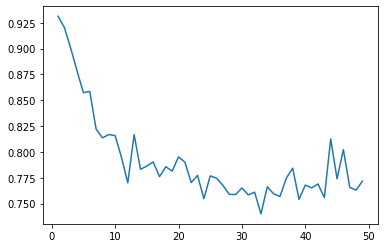

In [16]:
no_g_list = np.arange(1,no_g)
fidelity_list = np.zeros(len(no_g_list))
for j in no_g_list:
    avg_fidelity = 0
    tries = 100
    for i in range(tries):
        circuit = QuantumCircuit(no_q,no_q)
        initial_prob_list = benchmark(no_q,j,circuit)
        simulator = Aer.get_backend('qasm_simulator')
        result = execute(circuit,simulator,shots = shots,coupling_map=coupling_map,
                         noise_model=noise_model,
                         basis_gates=basis_gates).result()
        final_prob_list = final_problist(result.get_counts())
        avg_fidelity += fidelity(initial_prob_list,final_prob_list)
    avg_fidelity = avg_fidelity/tries
    fidelity_list[j-1] = avg_fidelity
plt.plot(no_g_list,fidelity_list)


In [ ]:
job = execute(circuit, backend = device)
from qiskit.tools.monitor import job_monitor
job_monitor(job)


In [16]:
no_q_list = np.arange(3,no_q + 2)
fidelity_list = np.zeros(len(no_q_list))
for j in no_q_list:
    avg_fidelity = 0
    tries = 50
    for i in range(tries):
        circuit = QuantumCircuit(int(j),int(j))
        initial_prob_list = benchmark(int(j),no_g,circuit)
        simulator = Aer.get_backend('qasm_simulator')
        result = execute(circuit,simulator,shots = shots,coupling_map=coupling_map,
                         noise_model=noise_model,
                         basis_gates=basis_gates).result()
        final_prob_list = final_problist(result.get_counts())
        avg_fidelity += fidelity(initial_prob_list,final_prob_list)
    avg_fidelity = avg_fidelity/tries
    fidelity_list[j-3] = avg_fidelity
plt.plot(no_q_list,fidelity_list)

QiskitError: 'Index out of range.'

[3 4 5]
